In [1]:
import os
from glob import glob

import random
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# tf input pipline
## tf.data.dataset 만들기

In [2]:
train_path = "./dataset/main_directory/"
test_path = "./dataset/test/"

INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img,INPUT_SHAPE[:2])
    return img

def make_dataset(filepaths,labels):
    filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filenames_ds.map(
        parse_image,
        num_parallel_calls=AUTOTUNE
    )
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    return ds

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [4]:
classes = os.listdir(train_path)
num_classes = len(classes)
print("number of classes :", num_classes)

filenames = glob(train_path+'*/*')
num_images = len(filenames)
print("number of images :", num_images)

print(filenames[0])
print(filenames[0].split(os.sep)[-2])
print()

random.shuffle(filenames)
labels = [classes.index(fn.split(os.sep)[-2]) for fn in filenames]

print("data 5 preview")
for path,label in zip(filenames[:5],labels[:5]):
    print(path)
    print("class :",classes[label])

number of classes : 11
number of images : 858
./dataset/main_directory\1\1_train_031.png
1

data 5 preview
./dataset/main_directory\7\7_train_426.png
class : 7
./dataset/main_directory\1\1_train_396.png
class : 1
./dataset/main_directory\7\7_train_018.png
class : 7
./dataset/main_directory\10-1\10-1_train_137.png
class : 10-1
./dataset/main_directory\9\9_train_267.png
class : 9


# 학습셋, 검증셋으로 나누기

In [5]:
train_x, val_x, train_y, val_y = train_test_split(
    filenames, labels, test_size=0.2,
    stratify=labels, random_state=1
)
num_train = len(train_x)
num_val = len(val_x)
print("number of training data :", num_train)
print("number of validation data :", num_val)

print("data 5 preview")
for path,label in zip(train_x[:5],train_y[:5]):
    print(path)
    print("class :",classes[label])

number of training data : 686
number of validation data : 172
data 5 preview
./dataset/main_directory\8\8_train_805.png
class : 8
./dataset/main_directory\5\5_train_513.png
class : 5
./dataset/main_directory\5\5_train_676.png
class : 5
./dataset/main_directory\4\4_train_510.png
class : 4
./dataset/main_directory\10-1\10-1_train_295.png
class : 10-1


In [6]:
train_ds = make_dataset(train_x, train_y)

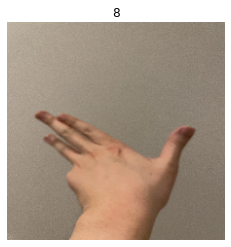

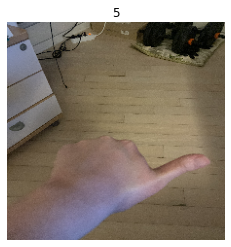

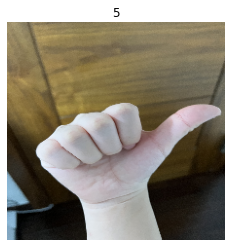

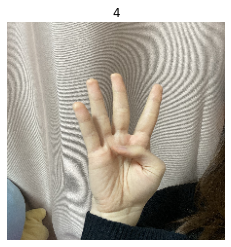

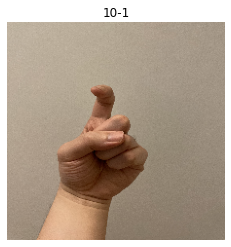

In [7]:
for img, label in train_ds.take(5):
    # print(img.numpy().shape)
    img = img.numpy()
    # print(img.min(), img.max())
    
    img = img.astype(np.uint8)
    idx = (label.numpy())
    
    plt.imshow(img), plt.axis('off')
    plt.title(classes[idx])
    plt.show()

In [8]:
val_ds = make_dataset(val_x, val_y)

In [9]:
# 모델 성능 높이기
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# data augmentation layer
## evaluate() 또는 predict() 호출 시에는 자동으로 비활성화 된다.

In [10]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
])

# model

In [11]:
transfer_model = keras.applications.Xception(
    input_shape= INPUT_SHAPE,
    include_top= False,
    weights= 'imagenet',
)
transfer_model.trainable = False
transfer_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [12]:
finetune_model = keras.Sequential([
    keras.Input(shape=INPUT_SHAPE),
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    transfer_model,
    keras.layers.Flatten(),
    keras.layers.Dense(2000, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=0.0002),
                       metrics='accuracy')                    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2000)              200706000 
                                                                 
 dense_1 (Dense)             (None, 11)                22011     
                                                                 
Total params: 221,589,491
Trainable params: 200,728,01

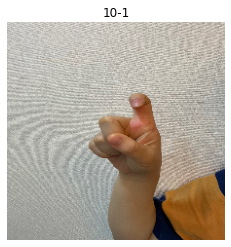

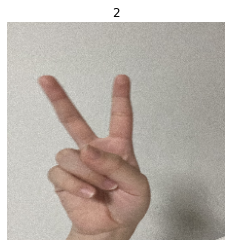

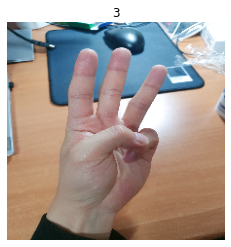

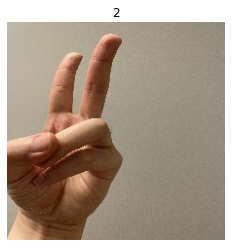

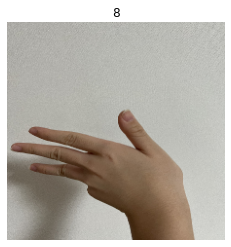

In [13]:
for batch in train_ds.take(1):
    for i in range(5):
        img = batch[0][i]
        # print(img.numpy().shape)
        img = img.numpy()
        # print(img.min(), img.max())
        
        img = img.astype(np.uint8)
        
        label = batch[1][i]
        idx = (label.numpy())
        
        plt.imshow(img), plt.axis('off')
        plt.title(classes[idx])
        plt.show()

In [14]:
train_step = num_train//BATCH_SIZE
val_step = num_val//BATCH_SIZE

filepath = "./model/{epoch:03d}-{val_loss:.4f}.h5"
check_point = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only = True,
    verbose = True
)
early_stop_point = keras.callbacks.EarlyStopping(patience=13)

tf.random.set_seed(7)

hist = finetune_model.fit(
    train_ds, epochs=10000,
    steps_per_epoch=train_step,
    validation_data=val_ds,
    validation_steps=val_step,
    callbacks = [check_point, early_stop_point]
)

Epoch 1/10000
21/21 [==============================] - ETA: 0s - loss: 9.7647 - accuracy: 0.2351 
Epoch 1: val_loss improved from inf to 2.49056, saving model to ./model\001-2.4906.h5
21/21 [==============================] - 116s 5s/step - loss: 9.7647 - accuracy: 0.2351 - val_loss: 2.4906 - val_accuracy: 0.4187
Epoch 2/10000
21/21 [==============================] - ETA: 0s - loss: 1.4906 - accuracy: 0.5657
Epoch 2: val_loss improved from 2.49056 to 1.13823, saving model to ./model\002-1.1382.h5
21/21 [==============================] - 110s 5s/step - loss: 1.4906 - accuracy: 0.5657 - val_loss: 1.1382 - val_accuracy: 0.6438
Epoch 3/10000
21/21 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.7095
Epoch 3: val_loss improved from 1.13823 to 0.74980, saving model to ./model\003-0.7498.h5
21/21 [==============================] - 106s 5s/step - loss: 0.8697 - accuracy: 0.7095 - val_loss: 0.7498 - val_accuracy: 0.7688
Epoch 4/10000
21/21 [==============================]

In [ ]:
plt.plot(hist.history["loss"], c='b', label="train_loss")
plt.plot(hist.history["val_loss"], c='r', label="val loss")
plt.lengend()
plt.show()